# WRF monthly summaries

This processing pipeline is for producing some monthly summaries for variables of interest for the SERDP Fish and Fire 1km interior AK WRF runs. It has been set up to run on Chinook, so dependencies are based on the available operating system (CentOS 6.10) and file paths and other parameters may be exclusively applicable to this system.

# 0 - Setup

Setup the file paths and create directories that will be used in this pipeline. 



In [1]:
# User parameters
# paths to directories
wrf_dir = "/import/SNAP/pbieniek/SERDP/hourly"
# will output to scratch space due to storage limitations on $HOME
out_dir = "/center1/DYNDOWN/kmredilla/data/serdp/wrf/monthly"


# setup

import os
from pathlib import Path
# imports used throughout this notebook
import numpy as np
import rasterio as rio
import xarray as xr
from rasterio.crs import CRS # need rasterio.crs.CRS instead of pyproj.crs.CRS

project_dir = Path(os.getenv("PROJECT_DIR"))
process_script = project_dir.joinpath("postprocess_wrf/summarize_monthly.py")
# conda init script - this is needed for getting conda ready in compute node
# envs since .bashrc is not sourced
conda_init_script = "/home/kmredilla/init_conda.sh"

wrf_dir = Path(wrf_dir)
out_dir = Path(out_dir)
out_dir.mkdir(exist_ok=True, parents=True)
slurm_dir = out_dir.joinpath("slurm")
slurm_dir.mkdir(exist_ok=True)
# filepath for storing the WRF projection metadata derived in this notebook
# to be referenced by sbatch jobs
proj_pkl_fp = slurm_dir.joinpath("proj_info.pickle")

# Target summary variable names and associated WRF variable names
varnames = {
    "tsk": "TSK", # mean skin temp
    "tskmax": "TSK", # max skin temp of the month
    "t2": "T2", # max 2m temp
    "t2max": "T2", # max 2m temp value of the month
    "prtot": "PCPNC", # total accumulation over month
    "prday": "PCPNC", # monthly mean daily precip
}

# models used, listed as they are found in the file paths
models = ["era", "ccsm", "gfdl"]

# make output directories for models and variables
for model in models:
    for varname in varnames:
        out_dir.joinpath(model, varname).mkdir(exist_ok=True, parents=True)

# 1 - Extract and summarize data

Pull out the variables of interest and summarize to monthly values.  

Variables of interest:
* `T2` - Two meter air temperature
* `TSK` - Surface temperature
* `PCPNC` - Precipitation



## 1.1 - Get the metadata necessary for creating GeoTIFFs:

### 1.1.1 - Project the WRF data

The WRF data does not have projection information in the output files, only lats/lons of center points, so the corresponding coordinates in the desired projection, EPSG:3338, need to be computed.

In [28]:
from pyproj import Proj, Transformer

In [29]:
geo_ds = xr.open_dataset("/import/SNAP/pbieniek/SERDP/wrf_files/geo_em.d01.nc")

# # create the WRF projection
wrf_proj = Proj(
    proj="lcc", # projection type: Lambert Conformal Conic
    lat_1=geo_ds.TRUELAT1, lat_2=geo_ds.TRUELAT2, # Cone intersects with the sphere
    lat_0=geo_ds.MOAD_CEN_LAT, lon_0=geo_ds.STAND_LON, # Center point
    a=6370000, b=6370000 # This is it! The Earth is a perfect sphere
) 
# WGS 
wgs_proj = Proj(proj='latlong', datum='WGS84')
dst_crs = CRS.from_epsg(3338)

transformer = Transformer.from_proj(wgs_proj, wrf_proj)
# Easting and Northings of the domains center point
e, n = transformer.transform(geo_ds.CEN_LON, geo_ds.CEN_LAT)
# Grid parameters
dx, dy = geo_ds.DX, geo_ds.DY
nx, ny = geo_ds.dims['west_east'], geo_ds.dims['south_north']
# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n
# upper right corner
x1 = x0 + dx * nx
y1 = y0 + dy * ny

### 1.1.2 - Create the GeoTIFF metadata

Create the metadata needed for reprojecting from the WRF projection to AK Albers 3338 and writing to disk.

Determine the transform of the WRF grid:

In [30]:
bounds = (x0, y0, x1, y1) # WSEN

src_transform = rio.transform.from_bounds(*bounds, nx, ny)
print(src_transform)

| 1000.00, 0.00, 105649.04|
| 0.00,-1000.00, 114659.04|
| 0.00, 0.00, 1.00|


Determine the transform and shape of the optimal output grid:

In [31]:
from rasterio.warp import calculate_default_transform


# the Proj-based crs attribute does not have a wkt attribute but that
# can be created from .to_wkt method. That attribute is needed for
# calculate_default_transform
wrf_crs = CRS.from_wkt(wrf_proj.crs.to_wkt())

dst_transform, dst_width, dst_height = calculate_default_transform(wrf_crs, dst_crs, nx, ny, *bounds)
print(dst_transform)
dst_shape = (dst_height, dst_width)
print("Output raster shape:", dst_shape)

| 972.91, 0.00, 193798.56|
| 0.00,-972.91, 1779315.03|
| 0.00, 0.00, 1.00|
Output raster shape: (224, 348)


Make the metadata dictionary:

In [32]:
meta = {
    "driver": "GTiff",
    "crs": dst_crs,
    "compress": "lzw",
    "dtype": rio.float32,
    "count": 1,
    "height": dst_height,
    "width": dst_width,
    "transform": dst_transform,
    "nodata": np.nan,
}

Pickle this stuff in `slurm_dir` for repeated use in `sbatch` jobs:

In [34]:
import pickle


spatial_di = {
    "meta": meta,
    "src_transform": src_transform,
    "wrf_crs": wrf_crs,
}

with open(proj_pkl_fp, "wb") as pkl:
    pickle.dump(spatial_di, pkl, protocol=pickle.HIGHEST_PROTOCOL)

## 1.2 - Summarize data and write to GeoTIFFs with slurm

Create the `.slurm` scripts needed to run `sbatch` jobs that call the `summarize_monthly.py` script with arguments for unique combinations of model and year. Define a function to write those scripts:

In [4]:
def write_sbatch(ncores, slurm_email, process_script, process_args, parition):
    """Write the SBATCH `.slurm` script for a model / year monthly summary
    
    Args:
        ncores (int): number of cpus to allocate per job
        slurm_email (str): email address for sending slurm messages
        process_script (pathlib.PosixPath): path to script for processing the monthly summaries
        process_args (dict): dictionary containing args for the processing script
        partition (str): "name of partition to use"
        
    Returns:
        filepath of `.slurm` script 
        
    Notes:
        ap_conda_env (str): name of the conda env that has anaconda-project installed
            (removed due to issue with Chinook)
    """
    out_dir = process_args["out_dir"]
    wrf_dir = Path(process_args["wrf_dir"])
    model = wrf_dir.parent.name
    year = wrf_dir.name
    head = (
        "#!/bin/sh\n"
        "#SBATCH --nodes=1\n"
        f"#SBATCH --cpus-per-task={ncores}\n"
        "#SBATCH --mail-type=FAIL\n"
        f"#SBATCH --mail-user={slurm_email}\n"
        f"#SBATCH --output={slurm_dir}/monthly_summary_{model}_{year}_slurm_%j.out\n"
        f"#SBATCH -p {parition}\n\n"
    )
    
    args = (
        # print start time
        "echo Start slurm && date\n"
        # prepare shell for using activate
        f"source {conda_init_script}\n"
        
        # okay this is not the desired way to do this, but Chinook compute
        # nodes are not working with anaconda-project, so we activate
        # this manually then run the python command
        f"conda activate {project_dir}/envs/default\n"
        
        # commented out proper way to do things in case issue on Chinook is fixed
        # activate env with anaconda-project installed
        # f"conda activate {ap_conda_env}\n"
        # f"cd {project_dir}\n"
        # call the python regression script
        # f"anaconda-project run python {process_script} "
        
        f"python {process_script} "
        f"-w {process_args['wrf_dir']} "
        f"-o {out_dir} "
        f"-p {proj_pkl_fp} "
        # just use the whole number of cores allocated for the sbatch
        f"-nc {ncores} "
    )
    
    # slurm_dir is global variable
    slurm_fp = slurm_dir.joinpath(f"monthly_summary_{model}_{year}.slurm")
    with open(slurm_fp, "w") as f:
        f.write(head + args)

    return slurm_fp

Write all of the `sbatch` job scripts, one for each model and year combination. Set the constant variables to be used:

In [24]:
ncores = 24
slurm_email = "kmredilla@alaska.edu"
parition = "t1small"

Then iterate through unique model / years and write the scripts:

In [45]:
slurm_fps = []
for model in models:
    if model == "era":
        years = np.arange(1979, 2019)
    else:
        years = np.array([
            np.arange(2007, 2019),
            np.arange(2037, 2049),
            np.arange(2067, 2079),
        ]).flatten()
    for year in years:
        process_args = {
            "wrf_dir": wrf_dir.joinpath(model, str(year)),
            "out_dir": out_dir
        }
        slurm_fp = write_sbatch(ncores, slurm_email, process_script, process_args, parition)
        slurm_fps.append(slurm_fp)

Submit all slurm scripts:

In [130]:
import subprocess


# define it without re-creating all slurm files
try:
    slurm_fps = slurm_fps
except NameError:
    slurm_fps = list(slurm_dir.glob("*.slurm"))

# stdout redirect just to silence submission confirmations
_ = [subprocess.Popen(["sbatch", fp], stdout=open(os.devnull, 'wb')) for fp in slurm_fps]

## 3 - Validation

### 3.1 - raster map plots

Show some plots of the resulting summary rasters. Define a function to show the rasters for all variables of a particular year model, showing a randomly selected month for each:

In [134]:
import matplotlib.pyplot as plt
from rasterio.plot import show


def show_allvar_rasters(model, year):
    # just pick a random month for each
    month = str(np.random.randint(1, 13)).zfill(2)
    
    def get_plot_range(varnames):
        """get the plot range from the arrays for related variables"""
        vmin, vmax = 0, 0
        for varname in varnames:
            fp = out_dir.joinpath(model, varname, f"{varname}_monthly_wrf_{model}_{year}_{month}.tif")
            # need to read each arr to get min/max first
            with rio.open(fp) as src:
                arr = src.read(1)
                vmin = min(np.nanmin(arr), vmin)
                vmax = max(np.nanmax(arr), vmax)
        return vmin, vmax
    
    vmin, vmax = get_plot_range(["tsk", "tskmax", "t2", "t2max"])
    # array to generate the cbar from
    cbar_arr = np.array([[vmin, vmax], [vmax, vmin]])
    cbar_im = plt.imshow(cbar_arr)
    plt.close()
    
    # then iterate to plot 
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18, 5))
    for varname, ax in zip(["tsk", "tskmax", "t2", "t2max"], axes.flat):
        fp = out_dir.joinpath(model, varname, f"{varname}_monthly_wrf_{model}_{year}_{month}.tif")
        with rio.open(fp) as src:
            show(src, ax=ax, vmin=vmin, vmax=vmax)
            ax.set_title(f"{varname}, month={month}")
        
    fig.subplots_adjust(bottom=0.02)
    cbar_ax = fig.add_axes([0.33, 0.05, 0.33, 0.05])
    fig.colorbar(cbar_im, cax=cbar_ax, orientation="horizontal")
    plt.show()
    
    # iterate to plot precip vars
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
    for varname, ax in zip(["prtot", "prday"], axes.flat):
        fp = out_dir.joinpath(model, varname, f"{varname}_monthly_wrf_{model}_{year}_{month}.tif")
        with rio.open(fp) as src:
            show(src, ax=ax, interpolation="none")
            ax.set_title(f"{varname}, month={month}")
        fig.colorbar(ax.images[0], ax=ax, shrink=0.5)
    
    plt.show()

Do this for a sample of years / models:

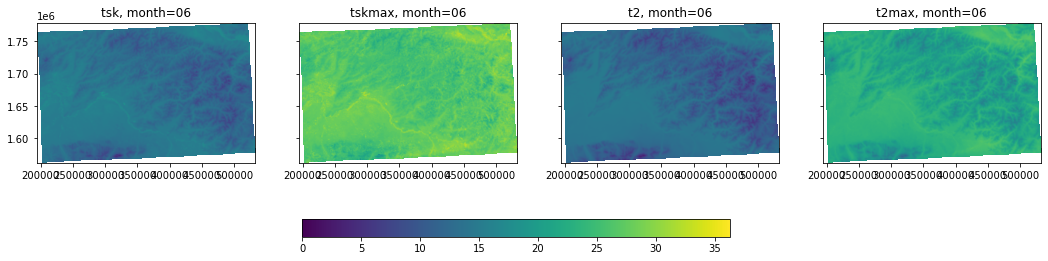

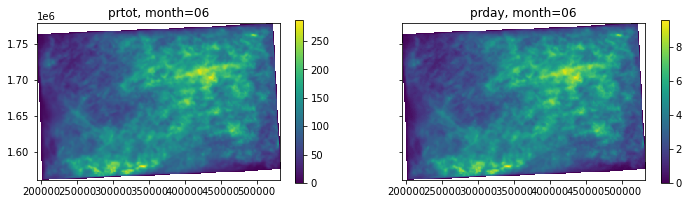

In [135]:
show_allvar_rasters("era", 1980)

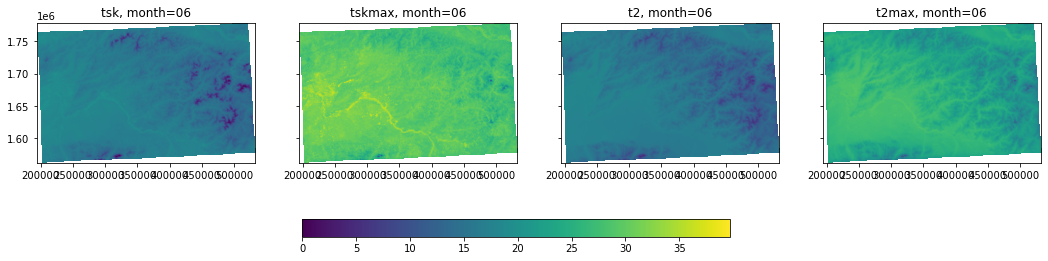

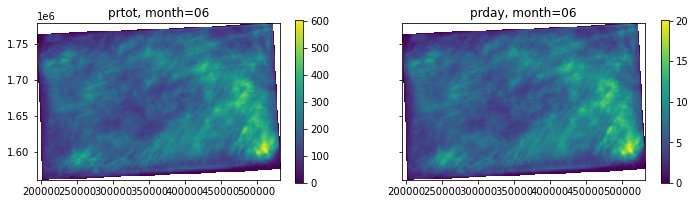

In [136]:
show_allvar_rasters("gfdl", 2040)

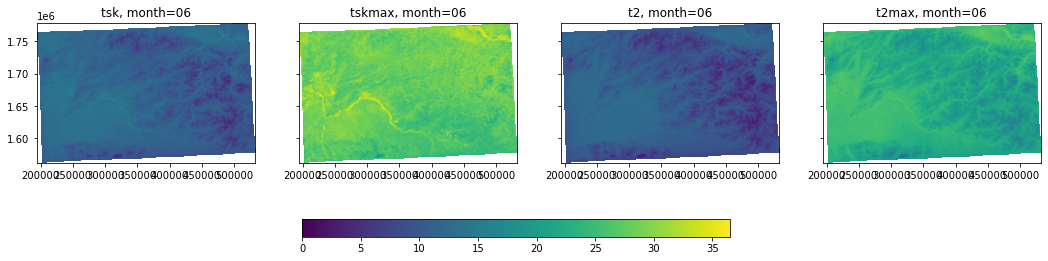

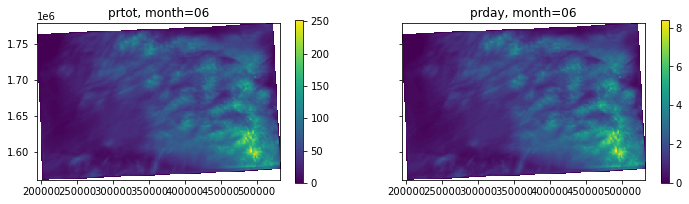

In [137]:
show_allvar_rasters("ccsm", 2012)

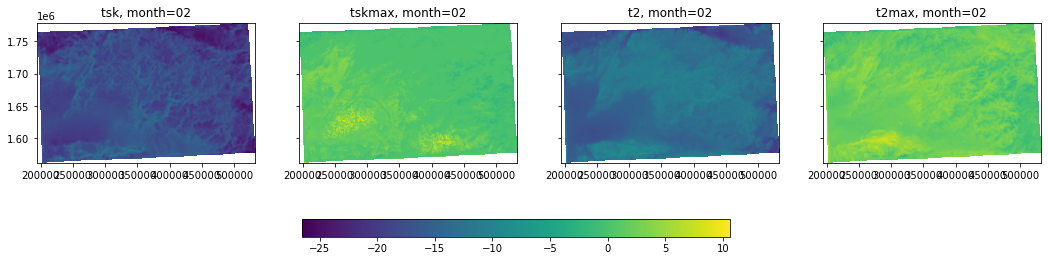

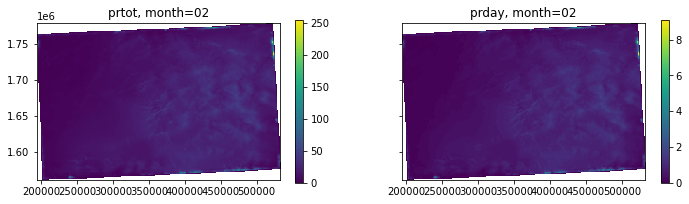

In [138]:
show_allvar_rasters("era", 2015)

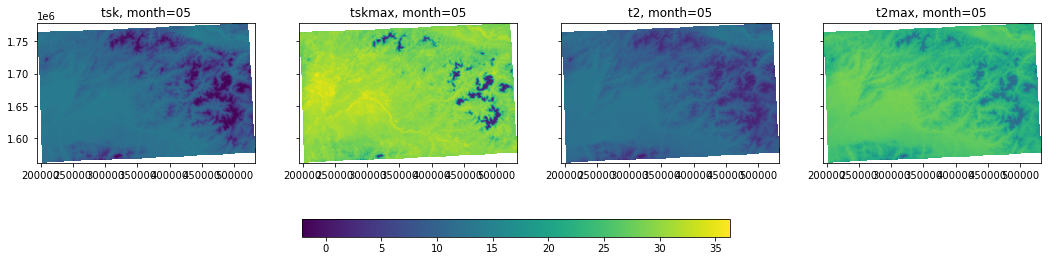

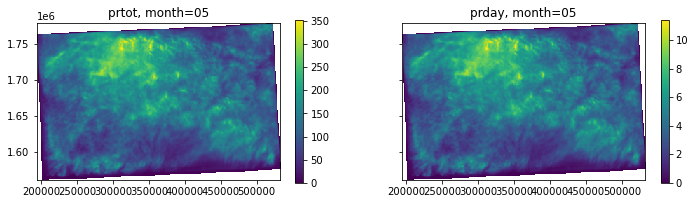

In [139]:
show_allvar_rasters("gfdl", 2070)

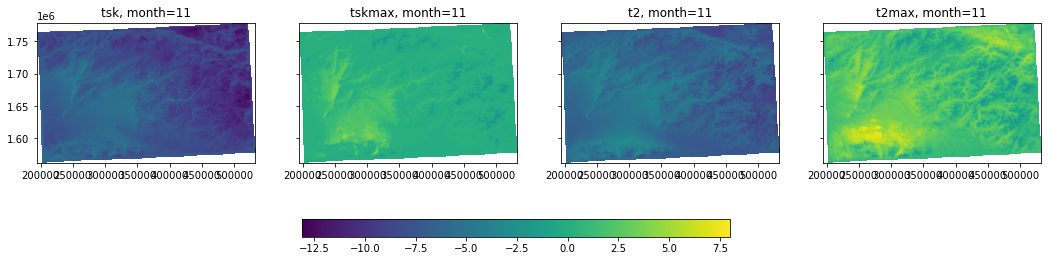

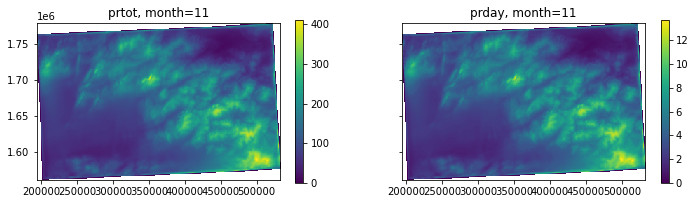

In [140]:
show_allvar_rasters("ccsm", 2042)

### 3.2 - validate computations

Do some re-computations of samples from the raw data and compare with the output summary data.

After much testing to determine the cause of some slight differences between the test outputs and summaries re-created from compiling all hourly values into numpy ndarrays and chaining the summary methods (e.g. `arr.mean(axis=0).mean(axis=0)`), I've found that the order of operations matters. I.e., an array created from a list of summarized daily arrays is not exactly equal to an array derived from an hourly array and summarized over the hour dimension. For example:

In [141]:
base_arr = np.random.uniform(274.37732, 289.2034, size=(24, 30, 209, 339))

# current strategy in sumarize_monthly.py
day_arr_summary = np.array([
    arr.mean(axis=0) for i in np.arange(30) for arr in base_arr[:,i,...]
]).mean(axis=0)

# original testing strategy
np.all(base_arr.mean(axis=0).mean(axis=0) == day_arr_summary)

False

So the testing should summarize to lists of daily arrays first, then create arrays for monthly summaries from those.

Define a function to read and summarize the hourly wrf data to daily for all variables of interest:

In [5]:
def read_wrf_data(fp):
    day_arrays = {}
    with xr.open_dataset(fp) as ds:
        day_arrays["t2"] = ds["T2"].values.mean(axis=0)
        day_arrays["t2max"] = ds["T2"].values.max(axis=0)
        day_arrays["tsk"] = ds["TSK"].values.mean(axis=0)
        day_arrays["tskmax"] = ds["TSK"].values.max(axis=0)
        day_arrays["prtot"] = ds["PCPNC"].values.sum(axis=0)
    day_arrays["prday"] = day_arrays["prtot"]
    
    return day_arrays

Define a function to summarize all days of a particular month, year, and model:

In [8]:
from multiprocessing import Pool


def make_day_arrays(month_fps):
    with Pool(24) as pool:
        pool_list = pool.map(read_wrf_data, month_fps)

    day_arrays = {
        "t2": [],
        "t2max": [],
        "tsk": [],
        "tskmax": [],
        "prtot": [],
    }
    for arr_di in pool_list:
        for key in day_arrays:
            day_arrays[key].append(arr_di[key])

    day_arrays = {key: np.array(day_arrays[key]) for key in day_arrays}
    
    return day_arrays

Load the same spatial info derived in section 1.1 above:

In [10]:
import pickle


with open(proj_pkl_fp, "rb") as pkl:
    spatial_di = pickle.load(pkl)
    
meta = spatial_di["meta"]

Define a function for reprojecting the data in the same way as was done for outputs:

In [11]:
from rasterio.warp import reproject, Resampling


def reproject_summary(arr):
    arr = np.flipud(arr)
    dst_arr = np.zeros((meta["height"], meta["width"]), np.float32)
    out = reproject(
        arr,
        dst_arr,
        src_transform=spatial_di["src_transform"],
        src_crs=spatial_di["wrf_crs"],
        dst_transform=meta["transform"],
        dst_crs=meta["crs"],
        dst_nodata=meta["nodata"],
        resampling=Resampling.bilinear
    )
    
    return dst_arr

Define a function to read a summary GeoTIFF output file based on model, varname, year, month:

In [12]:
def read_summary_geotiff(model, varname, year, month):
    fp = out_dir.joinpath(model, varname, f"{varname}_monthly_wrf_{model}_{year}_{month}.tif")
    with rio.open(fp) as src:
        arr = src.read(1)
    # set nodata to -9999 for testing
    arr[np.isnan(arr)] = -9999
    
    return arr

Define a function to iterate over variable names and compute monthly summaries from the daily summaries, and test equality with the summary output data:

In [17]:
def run_test(model, year):
    # test runs for a random month
    month = str(np.random.randint(1, 13)).zfill(2)
    month_fps = list(wrf_dir.joinpath(model, year).glob(f"*_{year}-{month}-*.nc"))
    day_arrays = make_day_arrays(month_fps)
    results = []
    for varname in day_arrays:
        if varname in ["t2", "tsk", "prday"]:
            new_arr = day_arrays[varname].mean(axis=0)
        elif varname in ["tskmax", "t2max"]:
            new_arr = day_arrays[varname].max(axis=0)
        elif varname == "prtot": 
            new_arr = day_arrays[varname].sum(axis=0)
        new_arr = reproject_summary(new_arr)
        if varname in ["tsk", "tskmax", "t2", "t2max"]:
            new_arr -= 273.15
        new_arr[np.isnan(new_arr)] = -9999
        new_arr = np.round(new_arr, 1)

        test_arr = read_summary_geotiff(model, varname, year, month)
        results.append(np.all(new_arr == test_arr))
    
    print("All arrays matched: ", np.all(results))
    
    return

Test a sample of different models and years:

In [18]:
model = "era"
year = "1980"

run_test(model, year)

All arrays matched:  True


In [19]:
model = "gfdl"
year = "2046"

run_test(model, year)

All arrays matched:  True


In [20]:
model = "ccsm"
year = "2010"

run_test(model, year)

All arrays matched:  True


In [21]:
model = "era"
year = "1990"

run_test(model, year)

All arrays matched:  True


In [22]:
model = "gfdl"
year = "2068"

run_test(model, year)

All arrays matched:  True


In [23]:
model = "ccsm"
year = "2072"

run_test(model, year)

All arrays matched:  True
